# 课后作业，蘑菇分类模型Fine-Tune
上一个阶段使用ModelArts训练了一个蘑菇分类器，该分类器可以对9种蘑菇进行分类。

现在，请使用上一个阶段训练好的网络作为本作业的backbone网络，训练一个可以分类另外2种新蘑菇的分类器。

### 数据集
本作业使用kaggle的[另一个蘑菇数据集](https://www.kaggle.com/anilkrsah/deepmushroom)，只需对其中的两种新蘑菇进行分类：
* Exidia：黑耳，又称为黑胶菌，分布于我国吉林、河北、山西、宁夏、青海、四川、广西、海南,西藏等地，无毒。
* Inocybe：丝盖伞，又称毛丝盖菌、毛锈伞，分布于我国河北、吉林、江苏、山西、四川、云南、甘肃、新疆等地，有毒。

# 范例代码
❋ 数据集切分可参考阶段1。

### 环境准备

本实验需要以下第三方库：
1. MindSpore 1.1.1
2. Numpy 1.17.5
3. matplotlib 3.3.4
4. easydict 1.9

Python 环境导入

In [1]:
from mindspore import Tensor
from mindspore.train.model import Model
import mindspore.nn as nn
from mindspore import load_checkpoint
from mindspore import context

import random
import shutil # 文件处理相关
import os
import numpy as np
import matplotlib.pyplot as plt
from easydict import EasyDict as ed # 超参数保存

[WARNING] ME(17712:19908,MainProcess):2021-04-08-23:06:25.345.948 [mindspore\ops\operations\array_ops.py:2302] WARN_DEPRECATED: The usage of Pack is deprecated. Please use Stack.


MindSpore 环境设置

In [2]:
device_target = context.get_context('device_target') # 获取运行装置（CPU，GPU，Ascend）
dataset_sink_mode = True if device_target in ['Ascend','GPU'] else False # 是否将数据通过pipeline下发到装置上
context.set_context(mode = context.GRAPH_MODE, device_target = device_target, save_graphs=False) # 设置运行环境，静态图context.GRAPH_MODE指向静态图模型，即在运行之前会把全部图建立编译完毕

print(f'device_target: {device_target}')
print(f'dataset_sink_mode: {dataset_sink_mode}')

device_target: CPU
dataset_sink_mode: False


### 参数设置

In [3]:
# 数据路径
train_path = os.path.join('data', 'train')
test_path = os.path.join('data', 'test')

# 超参数
config = ed({
    # 训练参数
    'batch_size': 16,
    'epochs': 150,
    
    #网络参数
    'num_classes': 5,

    # 动态学习率调节
    'warmup_epochs': 5,
    'lr_init': 0.01,
    'lr_max': 0.1,

    # 优化器参数
    'momentum': 0.9,
    'weight_decay': 4e-5})

### 数据处理
Backbone网络使用ImageNet数据训练，故归一化时用到的mean和std使用ImageNet的mean和std。

In [4]:
from preprocess import create_dataset

### 网络定义

定义backbone网络，并载入预训练网络参数。

In [5]:
from network import resnet50_backbone
backbone_net = resnet50_backbone()
load_checkpoint('best_param_backbone.ckpt', backbone_net)

[WARNING] ME(17712:19908,MainProcess):2021-04-08-23:06:27.421.53 [mindspore\train\serialization.py:406] Remove parameter prefix name: backbone., continue to load.


{'backbone.conv1.weight': Parameter (name=backbone.conv1.weight),
 'backbone.bn1.moving_mean': Parameter (name=backbone.bn1.moving_mean),
 'backbone.bn1.moving_variance': Parameter (name=backbone.bn1.moving_variance),
 'backbone.bn1.gamma': Parameter (name=backbone.bn1.gamma),
 'backbone.bn1.beta': Parameter (name=backbone.bn1.beta),
 'backbone.layer1.0.conv1.weight': Parameter (name=backbone.layer1.0.conv1.weight),
 'backbone.layer1.0.bn1.moving_mean': Parameter (name=backbone.layer1.0.bn1.moving_mean),
 'backbone.layer1.0.bn1.moving_variance': Parameter (name=backbone.layer1.0.bn1.moving_variance),
 'backbone.layer1.0.bn1.gamma': Parameter (name=backbone.layer1.0.bn1.gamma),
 'backbone.layer1.0.bn1.beta': Parameter (name=backbone.layer1.0.bn1.beta),
 'backbone.layer1.0.conv2.weight': Parameter (name=backbone.layer1.0.conv2.weight),
 'backbone.layer1.0.bn2.moving_mean': Parameter (name=backbone.layer1.0.bn2.moving_mean),
 'backbone.layer1.0.bn2.moving_variance': Parameter (name=backbo

定义head网络，和backbone+head的整体网络结构。

head网络要衔接backbone网络，其输入维度即backbone网络的输出维度（2048x7x7）。

In [6]:
class HeadNet(nn.Cell):
    """
    衔接MobileNetV2Backbone的Head网络

    Args:
        input_channel (int): 输入通道数
        class_num (int): 数据集分类数量
    Returns:
        Tensor, 输出张量

    Examples:
        >>> MobileNetV2(num_classes=1000)
    """

    def __init__(self, num_classes=1000):
        super(HeadNet, self).__init__()
        self.avg = nn.AvgPool2d(kernel_size=7)
        self.flat = nn.Flatten()
        self.fc = nn.Dense(2048, num_classes, has_bias=True)

    def construct(self, x):
        x = self.avg(x)
        x = self.flat(x)
        x = self.fc(x)
        return x


class ResNet50Combine(nn.Cell):
    """
    连接MobileNetV2Backbone和HeadNet的网络

    Args:
        backbone (Cell): 预训练网络（特征提取）
        head (Cell): 末端全连接网络（输出类）
    Returns:
        Tensor, 输出张量

    Examples:
        >>> MobileNetV2Combine(backbone, head)
    """

    def __init__(self, backbone, head):
        super(ResNet50Combine, self).__init__(auto_prefix=False)
        self.backbone = backbone
        self.head = head

    def construct(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x


### 特征提取
使用backbone网络对图像数据集进行推理，backbone网络的输出是图像数据的特征。提取出来的特征将作为head网络的训练数据使用。

In [7]:
def extract_features(net, data_path, config):
    """
    特征提取函数，使用backbone网络提取数据集特征

    参数:
       net(Cell): MobileNetV2的backbone网络
       data_path(str): 数据路径
       config(EasyDict): 超参数

    返回:
       int，step总数（总共几个batch）
    """
    
    # 创建文件夹用于存储数据集特征
    features_folder = os.path.join(data_path, '_features')
    if os.path.exists(features_folder):
        shutil.rmtree(features_folder)
    os.makedirs(features_folder)
    
    # 创建数据集
    dataset = create_dataset(data_path=data_path,
                             batch_size=config.batch_size)
    
    # 获取数据集step总数（几个批次）
    step_size = dataset.get_dataset_size()
    if step_size == 0: # 检查是否有成功生成至少1个批次
        raise ValueError('The step_size of dataset is zero. Check if the images count of train dataset is more than batch_size in config.py')

    
    # 特征提取
    for i, data in enumerate(dataset.create_dict_iterator(output_numpy=True)):
        # 定义模型
        model = Model(net)
        features_path = os.path.join(features_folder, f'feature_{i}.npy') # 特征数据储存路径
        label_path = os.path.join(features_folder, f'label_{i}.npy') # 对应标签储存路径
        image = data['image']
        label = data['label']
        features = model.predict(Tensor(image)) # 获取图像特征
        np.save(features_path, features.asnumpy()) # 保存特征数据
        np.save(label_path, label) # 保存对应标签
        print(f"Complete the batch {i+1}/{step_size}")
        
    return step_size


In [8]:
steps = extract_features(backbone_net,train_path, config)

Complete the batch 1/52
Complete the batch 2/52
Complete the batch 3/52
Complete the batch 4/52
Complete the batch 5/52
Complete the batch 6/52
Complete the batch 7/52
Complete the batch 8/52
Complete the batch 9/52
Complete the batch 10/52
Complete the batch 11/52
Complete the batch 12/52
Complete the batch 13/52
Complete the batch 14/52
Complete the batch 15/52
Complete the batch 16/52
Complete the batch 17/52
Complete the batch 18/52
Complete the batch 19/52
Complete the batch 20/52
Complete the batch 21/52
Complete the batch 22/52
Complete the batch 23/52
Complete the batch 24/52
Complete the batch 25/52
Complete the batch 26/52
Complete the batch 27/52
Complete the batch 28/52
Complete the batch 29/52
Complete the batch 30/52
Complete the batch 31/52
Complete the batch 32/52
Complete the batch 33/52
Complete the batch 34/52
Complete the batch 35/52
Complete the batch 36/52
Complete the batch 37/52
Complete the batch 38/52
Complete the batch 39/52
Complete the batch 40/52
Complete 

### 模型训练

设定动态学习率，加速模型收敛。

In [9]:
from lr_scheduler import get_lr
# 学习率数组
lr = get_lr(total_epochs=config.epochs, 
            steps_per_epoch=steps,
            lr_init=config.lr_init,
            lr_max=config.lr_max,
            warmup_epochs=config.warmup_epochs)

定义网络、损失函数、优化器、模型

因为提取的特征已经过批处理，这里使用TrainOneStepCell建立模型（一次训练一个batch）。

In [10]:
# 网络
head_net = HeadNet(num_classes=config.num_classes)

# 损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 优化器
opt = nn.Momentum(head_net.get_parameters(), lr, config.momentum, config.weight_decay)

# 模型（单批次训练）
network = nn.WithLossCell(head_net, net_loss) # 设定模型损失函数
network = nn.TrainOneStepCell(network, opt) # 设定模型优化器

训练模型

这里也将记录训练耗时、loss等统计数据。

In [11]:
features_path = os.path.join(train_path, '_features') # 特征数据路径
idx_list = list(range(steps)) # 创建特征数据索引，后续通过索引获取特征数据，方便打乱数据顺序
hist_loss = [] # 记录loss，后续可视化用

# 训练head网络
for epoch in range(config.epochs):
    random.shuffle(idx_list) # 打乱特征数据
    losses = []
    for j in idx_list:
        # 载入特征数据和对应标签
        feature_np = np.load(os.path.join(features_path, f'feature_{j}.npy'))
        label_np = np.load(os.path.join(features_path, f'label_{j}.npy'))
        
        # 转换成模型接收的Tensor形态
        feature = Tensor(feature_np) 
        label = Tensor(label_np)
        
        # 训练一个batch，并记录loss
        losses.append(network(feature, label).asnumpy())
                
    avg_loss = np.mean(np.array(losses))
    print(f'epoch[{epoch+1}/{config.epochs}], avg_loss: {avg_loss}')
    
    hist_loss.append(avg_loss) # 记录每个epoch的平均loss，模型评估用

epoch[1/150], avg_loss: 0.6117110252380371
epoch[2/150], avg_loss: 0.3423568308353424
epoch[3/150], avg_loss: 0.3010334372520447
epoch[4/150], avg_loss: 0.2832564115524292
epoch[5/150], avg_loss: 0.2525976300239563
epoch[6/150], avg_loss: 0.2528035044670105
epoch[7/150], avg_loss: 0.20119208097457886
epoch[8/150], avg_loss: 0.17439068853855133
epoch[9/150], avg_loss: 0.16496232151985168
epoch[10/150], avg_loss: 0.1589483916759491
epoch[11/150], avg_loss: 0.14303545653820038
epoch[12/150], avg_loss: 0.13366234302520752
epoch[13/150], avg_loss: 0.13350768387317657
epoch[14/150], avg_loss: 0.11856461316347122
epoch[15/150], avg_loss: 0.11768214404582977
epoch[16/150], avg_loss: 0.11690372973680496
epoch[17/150], avg_loss: 0.11035863310098648
epoch[18/150], avg_loss: 0.10607095062732697
epoch[19/150], avg_loss: 0.09861862659454346
epoch[20/150], avg_loss: 0.09602475166320801
epoch[21/150], avg_loss: 0.09109945595264435
epoch[22/150], avg_loss: 0.0901741236448288
epoch[23/150], avg_loss: 0.

### 模型评估

训练过程loss可视化

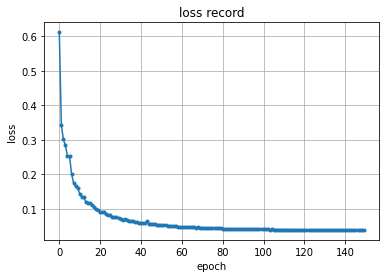

In [12]:
plt.plot(hist_loss, marker='.')
plt.title('loss record')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.show()
plt.close()

合并backbone_net与head_net，测试模型准确率

In [13]:
test_data = create_dataset(data_path=test_path, batch_size=config.batch_size)
net = ResNet50Combine(backbone_net, head_net) # 合并backbone_net与head_net
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
model = Model(net, loss_fn=net_loss, metrics={'acc'})
res = model.eval(test_data, dataset_sink_mode=dataset_sink_mode)

print(f'Result: {res}')

Result: {'acc': 0.9375}


### 效果展示

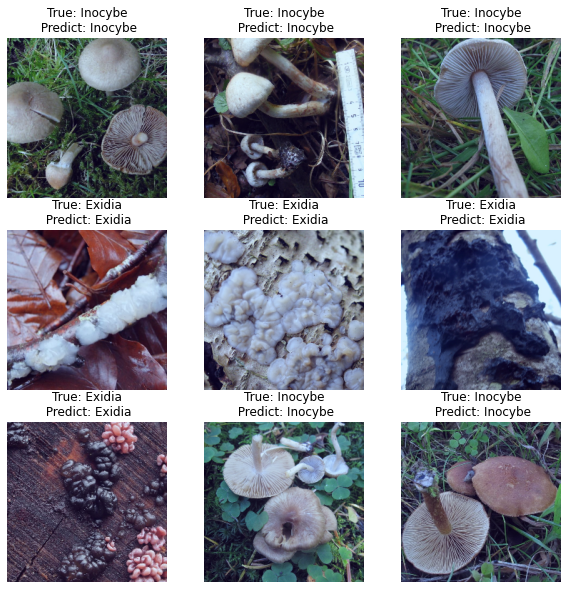

In [14]:
# 创建图像标签列表
category_dict = {0:'Exidia',1:'Inocybe'}

ds_test_demo = create_dataset(test_path, batch_size=1)

# 将数据归一化至0~1区间
def normalize(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

# 设置图像大小
plt.figure(figsize=(10,10))
i = 1
# 打印9张子图
for dic in ds_test_demo.create_dict_iterator():
    # 预测单张图片
    input_img = dic['image']
    output = model.predict(input_img)
    predict = np.argmax(output.asnumpy(),axis=1)[0] # 反馈可能性最大的类别
    
    # 可视化
    plt.subplot(3,3,i)
    input_image = np.squeeze(input_img.asnumpy(),axis=0).transpose(1,2,0) # 删除batch维度
    input_image = normalize(input_image) # 重新归一化，方便可视化
    plt.imshow(input_image)
    plt.axis('off')
    plt.title('True: %s\n Predict: %s'%(category_dict[dic['label'].asnumpy().item()],category_dict[predict]))
    i +=1
    if i > 9 :
        break

plt.show()